Datasets yang akan dipergunakan adalah https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

## Data Preparation

Import semua library yang dibutuhkan

In [1]:
# Import library
import os, zipfile, shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Install terlebih dahulu kaggle di dalam env google colab

In [2]:
# Install kaggle
!pip install -q kaggle

Upload file kaggle.json yang didapat dari menu

**My Account** >> **API** >> **Create New API Token**

In [3]:
# Upload json file downloaded from your kaggle account
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Setting persiapan untuk menerima datasets dari **Kaggle**

1.   Buat forlder baru khusus datasets kaggle, misalkan di `~/.kaggle`
2.   Copy paste file `kaggle.json` yang diupload tadi ke dalam folder tsb
3.   Ubah permission dari file json tersebut agar bisa dibaca
4.   Coba menggunakan perintah `kaggle datasets list` untuk melihat data

In [4]:
# Step 01
!mkdir ~/.kaggle

In [5]:
# Step 02
!cp kaggle.json ~/.kaggle/

In [6]:
# Step 03
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Step 04
!kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
jmmvutu/summer-products-and-sales-in-ecommerce-wish               Sales of summer clothes in E-commerce Wish        376KB  2020-08-23 15:16:46           2289  
Cornell-University/arxiv                                          arXiv Dataset                                     877MB  2020-08-14 23:50:57           1990  
agirlcoding/all-space-missions-from-1957                          All Space Missions from 1957                      101KB  2020-08-13 16:18:58           1379  
landlord/handwriting-recognition                                  Handwriting Recognition                             1GB  2020-08-05 17:20:36            455  
andrewmvd/heart-failure-clinical-data   

Selanjutnya adalah mendownload datasets yang diinginkan yang nantinya datasets tersebut akan masuk ke dalam folder `/content`

Datasets yang didownload masih dalam bentuk `zip` yang pada tahap selanjutnya akan dilakukan ekstraksi.

In [8]:
# Download datasets
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:02<00:00, 108MB/s]
100% 330M/330M [00:02<00:00, 116MB/s]


Ekstraksi datasets yang sudah didownload tadi dan lakukan set `BASE_DIR` untuk pemrosesan selanjutnya

In [9]:
# Extract datasets
local_zip = '/content/face-mask-12k-images-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
# Set base directory
BASE_DIR = '/content/Face Mask Dataset/'

Sebelum dilakukan pemrosesan ke tahap berikutnya, ada baiknya perlu diketahui terlebih dahulu mengenai jumlah data datasets.

In [11]:
# Create function to make the directory like tree-structure, without showing the files
def list_files(startpath):
  num_files = 0
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 2 * (level)
    num_files += len(files)
    print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))
  
  return num_files

In [12]:
# Check inside BASE_DIR
list_files(BASE_DIR)

/ 
Validation/ 
  WithoutMask/ 400 images
  WithMask/ 400 images
Train/ 
  WithoutMask/ 5000 images
  WithMask/ 5000 images
Test/ 
  WithoutMask/ 509 images
  WithMask/ 483 images


11792

Total datasets ada lebih dari 10,000 datasets terbagi ke dalam Train, Test, dan validation, dimana masing-masing data terbagi ke dalam image dengan masker (*WithMask*) dan tanpa masker (*WithoutMask*).

Mengingat dari datasets yang ada, diminta untuk membagi data training dan data validation dengan perbandingan 80% dan 20%, sedangkan data yang sudah terbagi tidak mengikuti perbandingan tersebut, maka kita perlu membaginya sesuai kriteria yang diminta.

In [13]:
# Create directories
def make_dirs(dirs):
  for dir in dirs:
    os.mkdir(dir)

# Delete directory All
def del_dirs():
  !rm -r '/content/Face Mask Dataset/All'

# Copy files to certain dirs
def copy_files(src, dst, symlinks=False, ignore=None):
  for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
      shutil.copy_files(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

In [14]:
del_dirs()

rm: cannot remove '/content/Face Mask Dataset/All': No such file or directory


In [15]:
# Create All directory
make_dirs(['/content/Face Mask Dataset/All'])

In [16]:
# Create subdirectories in All directory
make_dirs(['/content/Face Mask Dataset/All/WithoutMask', '/content/Face Mask Dataset/All/WithMask'])

Mengingat jumlah datasets Train dan Validation masih lebih dari 10,000 sampel (masih sesuai dengan kriteria submission), maka dari itu, datasets yang ada pada folder Test, nantinya akan digunakan untuk prediksi, sehingga tidak dilakukan copy file ke dalam folder `All`.

In [17]:
# Copy WithMask directory
copy_files('/content/Face Mask Dataset/Train/WithMask', '/content/Face Mask Dataset/All/WithMask')
# copy_files('/content/Face Mask Dataset/Test/WithMask', '/content/Face Mask Dataset/All/WithMask')
copy_files('/content/Face Mask Dataset/Validation/WithMask', '/content/Face Mask Dataset/All/WithMask')

In [18]:
# Copy WithoutMask directory
copy_files('/content/Face Mask Dataset/Train/WithoutMask', '/content/Face Mask Dataset/All/WithoutMask')
# copy_files('/content/Face Mask Dataset/Test/WithoutMask', '/content/Face Mask Dataset/All/WithoutMask')
copy_files('/content/Face Mask Dataset/Validation/WithoutMask', '/content/Face Mask Dataset/All/WithoutMask')

In [19]:
# Check length of data in All folders, is it same or not
list_files(BASE_DIR + 'All')

All/ 
  WithoutMask/ 5400 images
  WithMask/ 5400 images


10800

In [20]:
# Create FULL_DIRS directory as in /content/Face Mask Dataset/All
FULL_DIRS = BASE_DIR + 'All'

Selanjutnya, untuk memastikan bahwa ukuran dari image datasets tersebut beragam, maka dengan menggunakan PIL akan didapatkan hasilnya.

In [21]:
def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    # print path to all filenames.
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))
  
  return image_files

In [22]:
full_dirs = read_files(FULL_DIRS)
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

# Find a unique
unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 10800
Size unique images: 140
First 10 unique images: 
['121x121', '84x84', '65x65', '50x50', '156x156', '64x64', '82x82', '119x119', '126x126', '33x33']


Didapat bahwa dari total 10,800 gambar, ada sebanyak 140 jenis ukuran (ukuran beragam). Dan di tampilkan 10 contoh unique image sizes.

## Data Preprocessing dan Data Spliting

### Augmentasi Gambar

In [23]:
datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2, # 20% data validation
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=0.2
)

### Data Image Generator

In [24]:
HEIGHT = 120
WIDTH = 120

In [25]:
training_generator = datagen.flow_from_directory(
  FULL_DIRS,
  subset='training',
  target_size=(HEIGHT,WIDTH),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['WithoutMask','WithMask']
)

validation_generator = datagen.flow_from_directory(
  FULL_DIRS,
  subset='validation',
  target_size=(HEIGHT,WIDTH),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['WithoutMask','WithMask']
)

Found 8640 images belonging to 2 classes.
Found 2160 images belonging to 2 classes.


Jumlah data training dan validasi berturut-turut adalah 8,640 dan 2,160.

In [26]:
NUM_TRAINING_SAMPLES = training_generator.samples
NUM_VALIDATION_SAMPLES = validation_generator.samples
BATCH_SIZE = training_generator.batch_size
training_generator.class_indices

{'WithMask': 1, 'WithoutMask': 0}

## Modeling and Training

In [27]:
clear_session()
np.random.seed(42)
tf.random.set_seed(42)
    
model = Sequential([
    #1 convo2d & maxpool2d
    Conv2D(64, (3,3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    MaxPooling2D(2, 2),
    #2 convo2d & maxpool2d
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.6),
    #3 convo & maxpool2d
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #4 convo & maxpool2d
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    # Flatten
    Flatten(),
    # Hidden layers
    Dense(512, activation='relu'),
    Dropout(0.2),
    # Output, sigmoid output 0 or 1
    Dense(1, activation='sigmoid')
])

# Cek Summary
model.summary()

# Melihat plot model
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# Callback early stopping, 3x val_loss tdk ada perubahan, stop!
early_stopping_callback = EarlyStopping(
    patience=3,
    monitor='val_loss'
)

steps_per_epoch = NUM_TRAINING_SAMPLES // BATCH_SIZE
validation_steps = NUM_VALIDATION_SAMPLES // BATCH_SIZE
print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

# Compiling
LR = 1e-4
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=LR),
              metrics=['accuracy'])

# Fitting
result = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback
    ],
    verbose=1
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0

## Predicting and Evaluating

### Plot loss dan accuracy

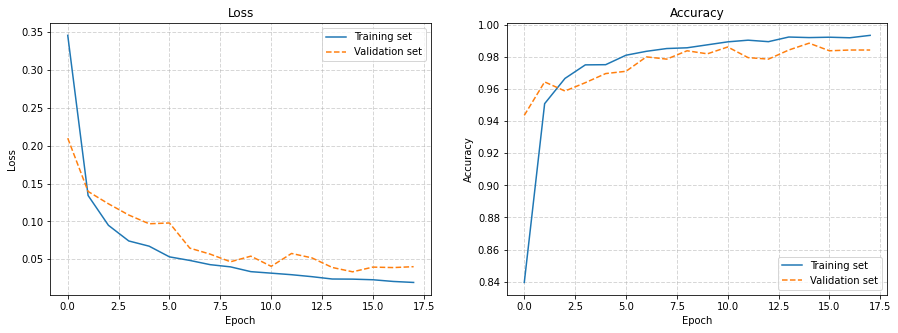

In [28]:
# Mengambil history dari loss dan accuracy
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

# Menampilkan graph loss dan accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

### Prediksi

Untuk prediksi face mask dataset, diambil dari folder `Face Mask Dataset/Test` mengingat dataset tersebut tidak kita gunakan saat training (jumlah dataset training sudah lebih dari 10,000 images).

In [29]:
TEST_WITHMASKS = '/content/Face Mask Dataset/Test/WithMask'
TEST_WITHOUTMASKS = '/content/Face Mask Dataset/Test/WithoutMask'

In [30]:
n_test_withmask = len(read_files(TEST_WITHMASKS))
n_test_withoutmask = len(read_files(TEST_WITHOUTMASKS))
n_test_withmask, n_test_withoutmask

(483, 509)

In [31]:
def plot_predicts(data):
  n_rows = np.ceil(len(data) / 5) # menyusun 5 gambar per baris
  fig = plt.figure(figsize=(20, 5 * n_rows))
  n_columns = 5

  for i in range(0, len(data)):
    fig.add_subplot(n_rows, n_columns, i + 1)
    plt.title(data[i]['title'])
    plt.xlabel(data[i]['file'])
    plt.imshow(data[i]['img'])
  
  plt.show()

def predict(data, start=0, end=10, batch_size=10):
  predicts = list()
  
  for d in data[start:end]: # Only some images
    predict = dict()

    img = keras.preprocessing.image.load_img(d, target_size=(HEIGHT,WIDTH))
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=batch_size)
    
    predict['img'] = img
    predict['file'] = d

    if classes[0][0] == 1:
      predict['title'] = 'WithMask'
    else:
      predict['title'] = 'WithoutMask'
    predicts.append(predict)
      
  return predicts

def n_prediction(predicts, type_pred=None):
  withmask = 0
  idx = 0
  while(idx < n_test_withmask):
    if predicts[idx]['title'] == type_pred:
      withmask += 1
    idx += 1

  return withmask, (len(predicts) - withmask)

In [32]:
withmask_true, withmask_false = n_prediction(predict(read_files(TEST_WITHMASKS), 0, n_test_withmask), 'WithMask')
withmask_true, withmask_false, withmask_true/n_test_withmask * 100

(475, 8, 98.34368530020704)

In [33]:
withoutmask_true, withoutmask_false = n_prediction(predict(read_files(TEST_WITHOUTMASKS), 0, n_test_withoutmask), 'WithoutMask')
withoutmask_true, withoutmask_false, withoutmask_true/n_test_withoutmask * 100

(479, 30, 94.10609037328095)

Hasil prediksi images baik yang menggunakan dan tidak menggunakan masker dapat mendeteksi hasil sebenarnya di atas 94%.

## TF-Lite

In [34]:
# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp1hxnb80i/assets


In [35]:
# Save model
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)